# HMIN339 :Méthodes Avancées de la Science de données


## **`Réconnaissance Visuelle de Plantes`**

### Object du Project :
Réconnaissance d'espèces de plantes à partir de photos

### Jeu de Départ : 
3474 images appartenant à 50 espèces différentes

### Encadrement :
* **`Konstantin TODOROV`**
* **`Pascal PONCELET`**
 
### Fait par :
* **`BEYA NTUMBA Joel`**
* **`MINKO AMOA Dareine`**
* **`QUENETTE Christophe`**
* **`SHAQURA Tasnim`**

In [1]:
import os
import glob
import json
import csv
import cv2
from PIL import Image
from matplotlib import pyplot
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as et
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = et.parse(xml_file)
        root = tree.getroot()
        value = (int(root.find('ObservationId').text),
                 int(root.find('MediaId').text),
                 float(root.find('Vote').text),
                 root.find('Content').text,
                 int(root.find('ClassId').text),
                 root.find('Family').text,
                 root.find('Genus').text,
                 root.find('Species').text,
                 root.find('Location').text,
                 root.find('Date').text
                 )
        xml_list.append(value)
    column_name = ['ObservationId', 'MediaId', 'Vote', 'Content', 'ClassId', 'Family', 'Genus', 'Species','Location','Date']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('Flowers.csv', index=None)
    print('Successfully converted xml to csv.')

main()

Successfully converted xml to csv.


In [3]:
df = pd.read_csv('flowers.csv')
df.head()

,ObservationId,MediaId,Vote,Content,ClassId,Family,Genus,Species,Location,Date
0,23116,1378,3.0,Flower,493,Asteraceae,Bellis,Bellis perennis L.,Palavas-les-Flots,2011-3-20
1,28135,15580,3.0,Flower,4477,Ranunculaceae,Anemone,Anemone alpina L.,Aston,2007-7-7
2,37273,97913,4.0,Flower,4516,Ranunculaceae,Ficaria,Ficaria verna Huds.,Vert-le-Petit,2013-4-21
3,25202,101501,4.0,Flower,2394,Cistaceae,Cistus,Cistus albidus L.,Narbonne,2012-4-11
4,11603,76867,3.0,Flower,5148,Salicaceae,Salix,Salix caprea L.,Sainte-Geneviève-des-Bois,2013-3-24


In [4]:
df.describe()

,ObservationId,MediaId,Vote,ClassId
count,3474.000000,3474.000000,3474.000000,3474.00000
mean,20576.090961,57254.248705,3.357159,8133.57110
std,11952.223278,33129.351823,0.719910,9328.44759
min,30.000000,23.000000,1.000000,151.00000
25%,10365.000000,28140.250000,3.000000,1286.00000
50%,20161.000000,57485.500000,3.000000,6418.00000
75%,30850.000000,86613.500000,4.000000,6564.00000
max,41776.000000,113154.000000,5.000000,32201.00000


In [5]:
len(df['Species'].value_counts())

50

In [6]:
def group_plants_species():
    with open('Flowers.csv', mode='r') as csv_file:
        grouped_plants = {}
        # species = []
        csv_reader = csv.DictReader(csv_file)

        for plant in csv_reader:
            species = plant["Species"]
            if species in grouped_plants:
                grouped_plants[species].append(plant["MediaId"])
            else:
                grouped_plants[species] = [plant["MediaId"]]
    
    # print dictionnary
    print(len(grouped_plants))
    print(json.dumps(grouped_plants, indent = 4))

In [7]:
image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
image_files = [os.path.basename(os.path.join(image_path, file))
         for file in os.listdir(image_path) if      file.endswith('.jpg')]

fileIds = []
for image_file in image_files:
    fileId = image_file.split('.')[0]
    fileIds.append(fileId)
        
        
    
# Creation of the Images Dataframe
df2 = pd.DataFrame({
    'filename': image_files,
    'MediaId': fileIds
})

# Conversion of types of MediaId rows from 'object' to 'int64'
df2["MediaId"] = pd.to_numeric(df2["MediaId"])

df2.head()

,filename,MediaId
0,48317.jpg,48317
1,75041.jpg,75041
2,64605.jpg,64605
3,5765.jpg,5765
4,83008.jpg,83008


In [8]:
df3 = pd.merge(df, df2, on='MediaId', how='inner')
df3[['MediaId','Species','filename']].head()

,MediaId,Species,filename
0,1378,Bellis perennis L.,1378.jpg
1,15580,Anemone alpina L.,15580.jpg
2,97913,Ficaria verna Huds.,97913.jpg
3,101501,Cistus albidus L.,101501.jpg
4,76867,Salix caprea L.,76867.jpg


In [9]:
# Copy of initial dataframe
data = df3.copy()

# Deleting non-useful columns
data=data.drop(['ObservationId', 'MediaId', 'Vote', 'Content', 
                'ClassId', 'Family', 'Genus','Location','Date'],
axis=1)

data.head()

,Species,filename
0,Bellis perennis L.,1378.jpg
1,Anemone alpina L.,15580.jpg
2,Ficaria verna Huds.,97913.jpg
3,Cistus albidus L.,101501.jpg
4,Salix caprea L.,76867.jpg


In [10]:
## function to load folder into arrays and then it returns that same array
def loadImages():
    # Put files into lists and return them as one list of size 4
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
    image_files = [os.path.join(image_path, file)
         for file in os.listdir(image_path) if      file.endswith('.jpg')]
    
    return image_files

image_files = loadImages()

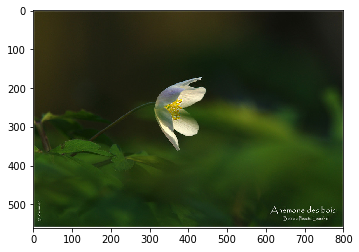

In [11]:
img=mpimg.imread(image_files[3400])
imgplot = plt.imshow(img)
plt.show()

In [23]:
##### Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [13]:
image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
image_files = [os.path.basename(os.path.join(image_path, file))
         for file in os.listdir(image_path) if      file.endswith('.jpg')]

fileIds = []
for image_file in image_files:
    fileId = image_file.split('.')[0]
    fileIds.append(fileId)
        
        
    
# Creation of the Images Dataframe
df2 = pd.DataFrame({
    'filename': image_files,
    'MediaId': fileIds
})

# Conversion of types of MediaId rows from 'object' to 'int64'
df2["MediaId"] = pd.to_numeric(df2["MediaId"])

df2.head()

,filename,MediaId
0,48317.jpg,48317
1,75041.jpg,75041
2,64605.jpg,64605
3,5765.jpg,5765
4,83008.jpg,83008


In [25]:
datafd=[]
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = et.parse(xml_file)
        root = tree.getroot()
        value = (int(root.find('ObservationId').text),
                 int(root.find('MediaId').text),
                 float(root.find('Vote').text),
                 root.find('Content').text,
                 int(root.find('ClassId').text),
                 root.find('Family').text,
                 root.find('Genus').text,
                 root.find('Species').text,
                 root.find('Location').text,
                 root.find('Date').text
                 )
        xml_list.append(value)
    column_name = ['ObservationId', 'MediaId', 'Vote', 'Content', 'ClassId', 'Family', 'Genus', 'Species','Location','Date']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

def main():
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('flowers.csv', index=None)
    print('Successfully converted xml to csv.')

main()

Successfully converted xml to csv.


In [26]:
temp = pd.read_csv('flowers.csv')
df = temp.sort_values(['MediaId'], ascending=True)
temp.head()

,ObservationId,MediaId,Vote,Content,ClassId,Family,Genus,Species,Location,Date
0,23116,1378,3.0,Flower,493,Asteraceae,Bellis,Bellis perennis L.,Palavas-les-Flots,2011-3-20
1,28135,15580,3.0,Flower,4477,Ranunculaceae,Anemone,Anemone alpina L.,Aston,2007-7-7
2,37273,97913,4.0,Flower,4516,Ranunculaceae,Ficaria,Ficaria verna Huds.,Vert-le-Petit,2013-4-21
3,25202,101501,4.0,Flower,2394,Cistaceae,Cistus,Cistus albidus L.,Narbonne,2012-4-11
4,11603,76867,3.0,Flower,5148,Salicaceae,Salix,Salix caprea L.,Sainte-Geneviève-des-Bois,2013-3-24


In [27]:
# load all images in a directory

def loadImages():
    image_files = sorted([os.path.join('small_dataset_train/train', file)
         for file in os.listdir('small_dataset_train/train') if      file.endswith('.jpg')])
    return image_files

In [28]:
def reloadImages():
    i =[]
    image_files = sorted([os.path.join('small_dataset_train/train/', file)
         for file in os.listdir('small_dataset_train/train/') if      file.endswith('.png')])
    for image in sorted(image_files):
        i.append(Image.open(image))
    return i

In [29]:
def processing(dataI):
    for i in dataI[:10]:
        img = Image.open(i)      
        temp= i.split('.')
        new_image = img.resize((220, 220))    
        greyscale_image = new_image.convert('L')
       # croppedIm = greyscale_image.crop((290, 250, 650, 650)) 
        name = str(temp[0])+'.png'       
       # croppedIm.save(name)
        greyscale_image.save(name)

In [30]:
def Histogram_Oriented_Gradients(images_list):
    listfig, listfd =[], []
    for image in images_list:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        listfig.append(hog_image_rescaled)
        listfd.append(fd)
        

    return listfig, listfd

In [31]:
def show_image(origin , y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(origin , cmap=plt.cm.gray)
    ax1.set_title('Input image')
   
    ax2.axis('off')
    ax2.imshow(y, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

List of files the first 10 in the folder:
 ['small_dataset_train/train/100019.jpg', 'small_dataset_train/train/100056.jpg', 'small_dataset_train/train/100087.jpg', 'small_dataset_train/train/100182.jpg', 'small_dataset_train/train/10019.jpg', 'small_dataset_train/train/100211.jpg', 'small_dataset_train/train/100250.jpg', 'small_dataset_train/train/100280.jpg', 'small_dataset_train/train/100310.jpg', 'small_dataset_train/train/100366.jpg']
--------------------------------


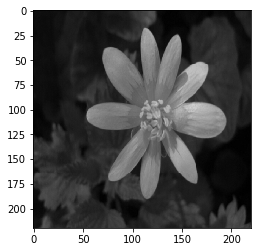

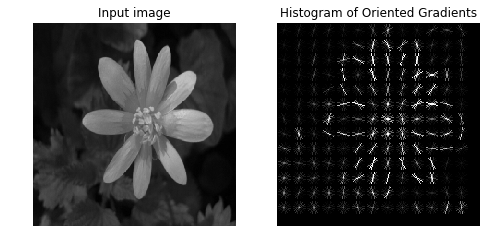

ValueError: Length of values does not match length of index

In [32]:
def main():
    # calling global variable

    '''The var Dataset is a list with all images in the folder '''
    dataset = loadImages()
    
    print("List of files the first 10 in the folder:\n",dataset[:10])
    print("--------------------------------")
    
    # sending all the images to pre-processing
    processing(dataset)
    dataset = reloadImages()
    pyplot.imshow(dataset[1])
    pyplot.show()
    
    dataset1, datafd = Histogram_Oriented_Gradients(dataset)
    show_image(dataset[1] , dataset1[1])
    return datafd
  
datafd = main()
df3 = pd.merge(df, df2, on='MediaId', how='inner')  
df3['vectore']=datafd
df3[['MediaId','Species','filename','vectore']]